In [72]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load Data

In [73]:

ratings_df = pd.read_csv('ratings_small.csv')
movies_df = pd.read_csv('movies_metadata.csv')

<ipython-input-73-af5da81a39ec>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_df = pd.read_csv('movies_metadata.csv')


# Step 2: Data Processing


In [38]:
# Filter movies that a user likes (rating > 3.5)
# liked_movies_df = ratings_df[ratings_df['rating'] > 3.5]

In [74]:
movies_df['id'] = pd.to_numeric(movies_df['id'], errors='coerce')
ratings_df['movieId'] = ratings_df['movieId'].astype('float64')

# Drop rows with NaN in 'id' after conversion
movies_df = movies_df.dropna(subset=['id'])

In [75]:
# Merge with movie metadata to get genres
movies_ratings_with_genre = ratings_df.merge(movies_df, left_on='movieId', right_on='id')


In [78]:
movies_ratings_with_genre.head(-10)

,userId,movieId,rating,timestamp,adult,belongs_to_collection,budget,genres,homepage,id,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,1,1371.0,2.5,1260759135,False,"{'id': 1575, 'name': 'Rocky Collection', 'post...",17000000,"[{'id': 18, 'name': 'Drama'}]",NaN,1371.0,...,1982-05-28,270000000.0,99.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The greatest challenge.,Rocky III,False,6.6,894.0
1,4,1371.0,4.0,949810302,False,"{'id': 1575, 'name': 'Rocky Collection', 'post...",17000000,"[{'id': 18, 'name': 'Drama'}]",NaN,1371.0,...,1982-05-28,270000000.0,99.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The greatest challenge.,Rocky III,False,6.6,894.0
2,7,1371.0,3.0,851869160,False,"{'id': 1575, 'name': 'Rocky Collection', 'post...",17000000,"[{'id': 18, 'name': 'Drama'}]",NaN,1371.0,...,1982-05-28,270000000.0,99.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The greatest challenge.,Rocky III,False,6.6,894.0
3,19,1371.0,4.0,855193404,False,"{'id': 1575, 'name': 'Rocky Collection', 'post...",17000000,"[{'id': 18, 'name': 'Drama'}]",NaN,1371.0,...,1982-05-28,270000000.0,99.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The greatest challenge.,Rocky III,False,6.6,894.0
4,21,1371.0,3.0,853852263,False,"{'id': 1575, 'name': 'Rocky Collection', 'post...",17000000,"[{'id': 18, 'name': 'Drama'}]",NaN,1371.0,...,1982-05-28,270000000.0,99.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The greatest challenge.,Rocky III,False,6.6,894.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44979,652,26791.0,5.0,1439588577,False,NaN,1000000,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,26791.0,...,2001-03-30,852206.0,119.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Brigham City,False,7.3,4.0
44980,652,26843.0,5.0,1440269953,False,NaN,35000000,"[{'id': 28, 'name': 'Action'}, {'id': 36, 'nam...",NaN,26843.0,...,1981-04-17,0.0,173.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,He was a man of honor in a war without any.,Lion of the Desert,False,7.5,36.0
44981,652,60086.0,4.0,1439587482,False,NaN,0,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",http://www.babysitterwantedfilm.com/,60086.0,...,2009-02-06,0.0,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,No experience necessary...,Babysitter Wanted,False,5.3,53.0
44982,652,69495.0,3.0,1442085805,False,NaN,0,"[{'id': 10770, 'name': 'TV Movie'}, {'id': 28,...",NaN,69495.0,...,2008-04-08,0.0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Lone Rider,True,4.4,4.0


# Step 3: Feature Engineering


In [79]:
import ast

def extract_genres(genres_str):
    try:
        genres = ast.literal_eval(genres_str)
        if not isinstance(genres, list):
            print(f"Unexpected format (not a list): {genres_str}")
            return []
        return [genre['name'] for genre in genres if 'name' in genre]
    except Exception as e:
        print(f"Error parsing genres: {genres_str}, Error: {e}")
        return []

movies_ratings_with_genre['genres'] = movies_ratings_with_genre['genres'].apply(extract_genres)


In [83]:
user_genre_df = movies_ratings_with_genre.explode('genres').groupby(['userId', 'genres']).mean()['rating'].unstack(fill_value=0)
# avg_rating_df = liked_movies_with_genre.groupby(['userId', 'genres']).mean()['rating'].unstack(fill_value=0)


<ipython-input-83-7921827f6f04>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  user_genre_df = movies_ratings_with_genre.explode('genres').groupby(['userId', 'genres']).mean()['rating'].unstack(fill_value=0)


In [84]:
user_genre_df.head()

genres,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.0,2.625000,2.500000,0.0,2.000000,0.0,0.000000,0.00,1.00,0.000000,0.000000,0.000000,3.000000,0.000000,0.0,0.000000,0.000000,0.0
2,3.555556,3.428571,5.0,3.562500,3.400000,4.0,3.475000,4.0,3.000000,0.00,3.25,3.500000,3.000000,3.375000,3.642857,3.166667,0.0,3.555556,4.000000,0.0
3,3.875000,3.625000,0.0,4.166667,3.100000,0.0,3.406250,4.0,4.000000,3.00,0.00,2.750000,0.000000,3.300000,3.600000,3.833333,4.0,3.900000,3.000000,0.0
4,4.480000,4.384615,5.0,4.187500,4.555556,5.0,4.138889,3.4,4.875000,5.00,4.75,4.444444,4.333333,4.555556,4.000000,4.105263,0.0,4.500000,4.666667,0.0
5,3.944444,3.300000,4.0,3.777778,4.055556,4.0,3.964286,3.5,4.083333,4.25,4.00,3.937500,4.000000,4.125000,3.857143,4.000000,0.0,4.083333,0.000000,2.5


In [55]:
user_genre_df['total_ratings'] = user_genre_df.sum(axis=1)

# Normalize each genre count by the total number of ratings for that user
for genre in user_genre_df.columns[:-1]:  # Exclude the total_ratings column
    user_genre_df[genre] = user_genre_df[genre] / user_genre_df['total_ratings']

# Drop the total_ratings column as it's no longer needed
user_genre_df = user_genre_df.drop(columns=['total_ratings'])

user_genre_df.head(10)
# print(user_genre_df.columns)

genres,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.080645,0.032258,0.016129,0.112903,0.064516,0.016129,0.290323,0.016129,0.000000,0.000000,0.016129,0.016129,0.000000,0.048387,0.161290,0.016129,0.000000,0.080645,0.032258,0.000000
3,0.076923,0.076923,0.000000,0.192308,0.000000,0.000000,0.192308,0.076923,0.038462,0.000000,0.000000,0.000000,0.000000,0.038462,0.115385,0.076923,0.038462,0.076923,0.000000,0.000000
4,0.095238,0.043290,0.012987,0.108225,0.069264,0.004329,0.229437,0.008658,0.034632,0.004329,0.017316,0.034632,0.021645,0.034632,0.082251,0.056277,0.000000,0.129870,0.012987,0.000000
5,0.082353,0.023529,0.011765,0.141176,0.070588,0.035294,0.200000,0.000000,0.070588,0.023529,0.011765,0.070588,0.011765,0.035294,0.047059,0.058824,0.000000,0.105882,0.000000,0.000000
6,0.142857,0.035714,0.000000,0.071429,0.142857,0.035714,0.178571,0.000000,0.035714,0.000000,0.000000,0.035714,0.000000,0.000000,0.071429,0.035714,0.000000,0.178571,0.000000,0.035714
7,0.093023,0.046512,0.000000,0.069767,0.023256,0.000000,0.279070,0.023256,0.069767,0.000000,0.023256,0.046512,0.000000,0.116279,0.093023,0.023256,0.000000,0.093023,0.000000,0.000000
8,0.068966,0.034483,0.017241,0.172414,0.034483,0.000000,0.275862,0.000000,0.017241,0.000000,0.000000,0.034483,0.034483,0.051724,0.103448,0.068966,0.000000,0.086207,0.000000,0.000000
9,0.150943,0.094340,0.000000,0.075472,0.056604,0.018868,0.188679,0.000000,0.037736,0.000000,0.000000,0.037736,0.018868,0.075472,0.018868,0.113208,0.000000,0.113208,0.000000,0.000000


# Step 4: Clustering


In [85]:
kmeans = KMeans(n_clusters=5)  # Adjust number of clusters as needed
user_genre_df['kmeans_cluster'] = kmeans.fit_predict(user_genre_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Step 5: Optimal Cluster Number


In [86]:
silhouette_scores = []
for n_clusters in range(2, 11):
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(user_genre_df)
    silhouette_avg = silhouette_score(user_genre_df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [87]:
print(silhouette_scores)

[0.1875492057139962, 0.16298515405816325, 0.13333759862808564, 0.1422215915816747, 0.12941367000588994, 0.1391923849244394, 0.12430020807803965, 0.11414792023155912, 0.125205940352685]


In [88]:
# Select the number of clusters with the highest silhouette score
optimal_clusters = np.argmax(silhouette_scores) + 2  # +2 because range starts at 2

In [89]:
# Step 6: t-SNE Visualization
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(user_genre_df)

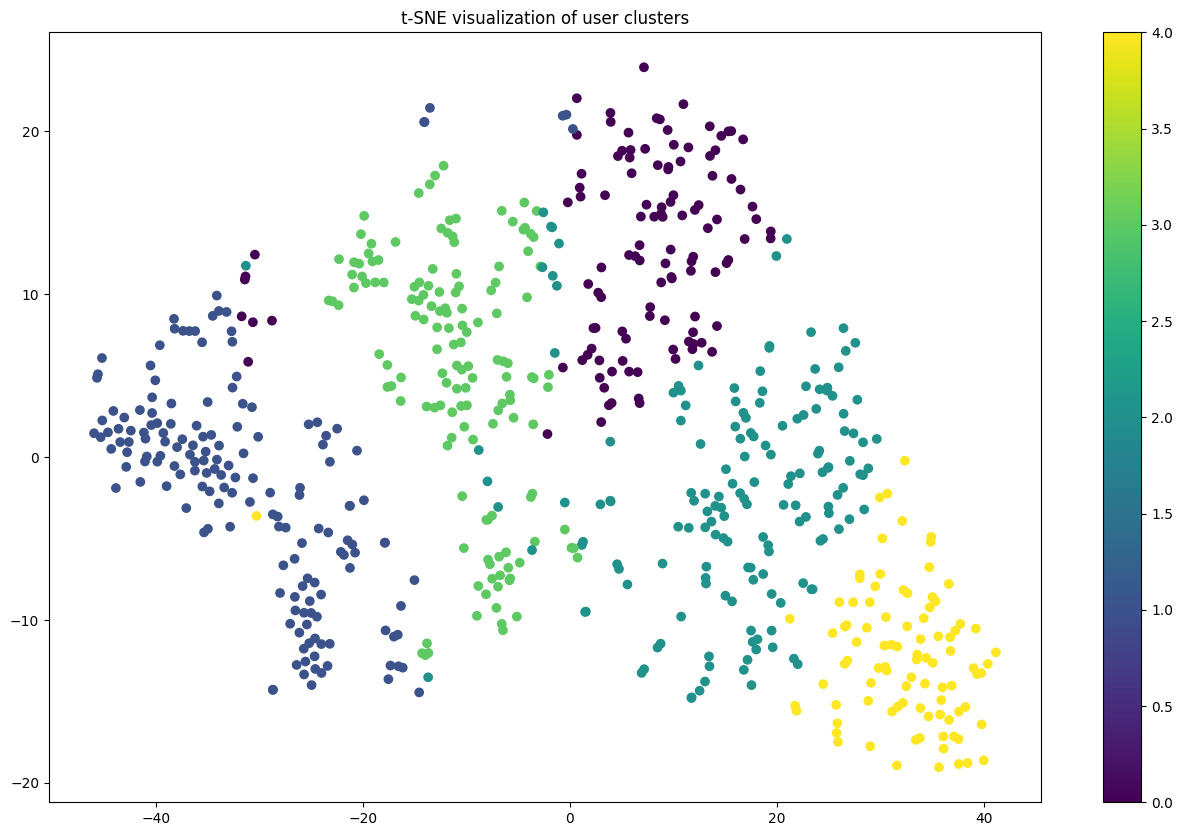

In [90]:
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=user_genre_df['kmeans_cluster'])
plt.colorbar()
plt.title('t-SNE visualization of user clusters')
plt.show()

Number of users in each cluster:
1    163
2    158
3    143
0    115
4     92
Name: kmeans_cluster, dtype: int64


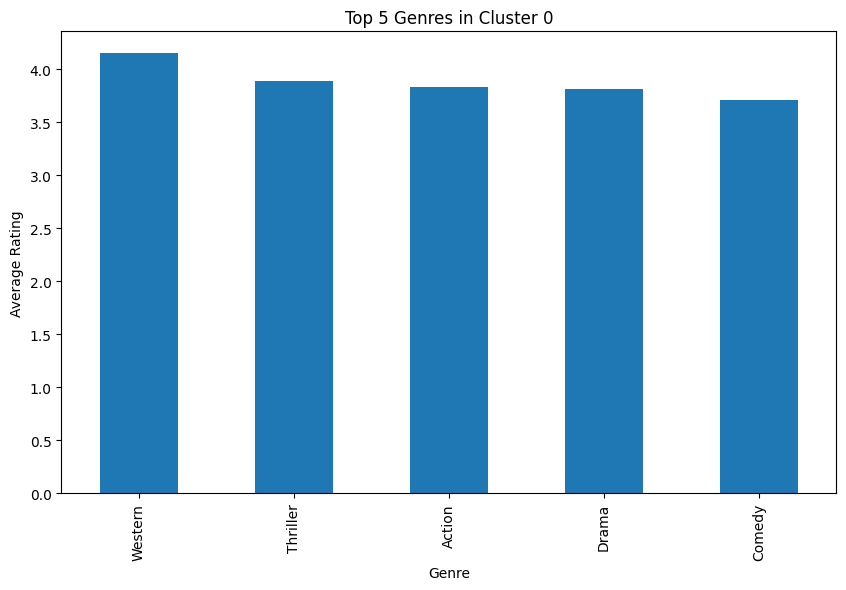

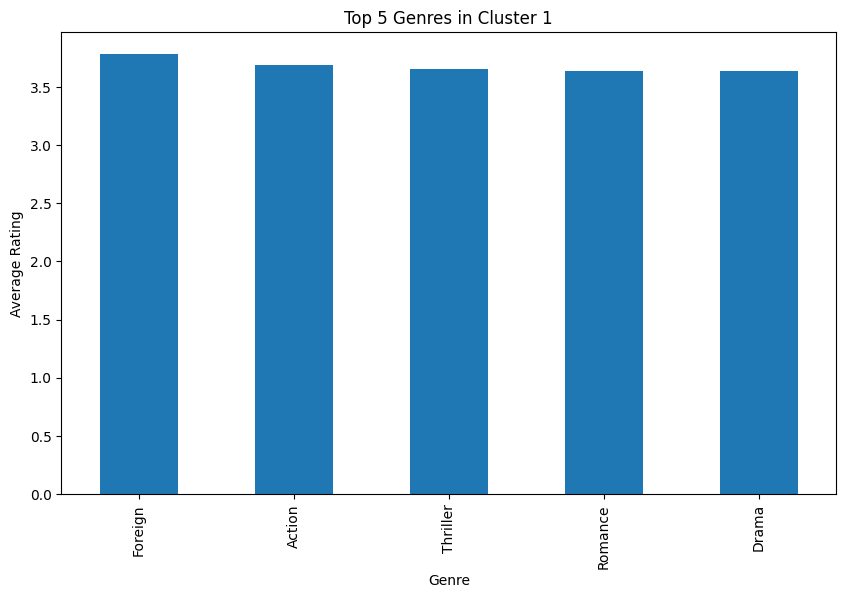

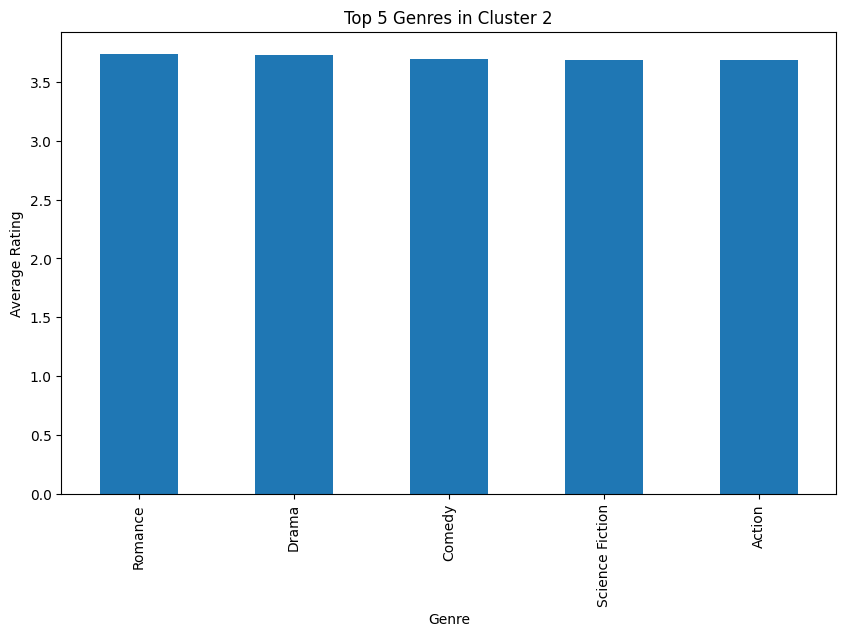

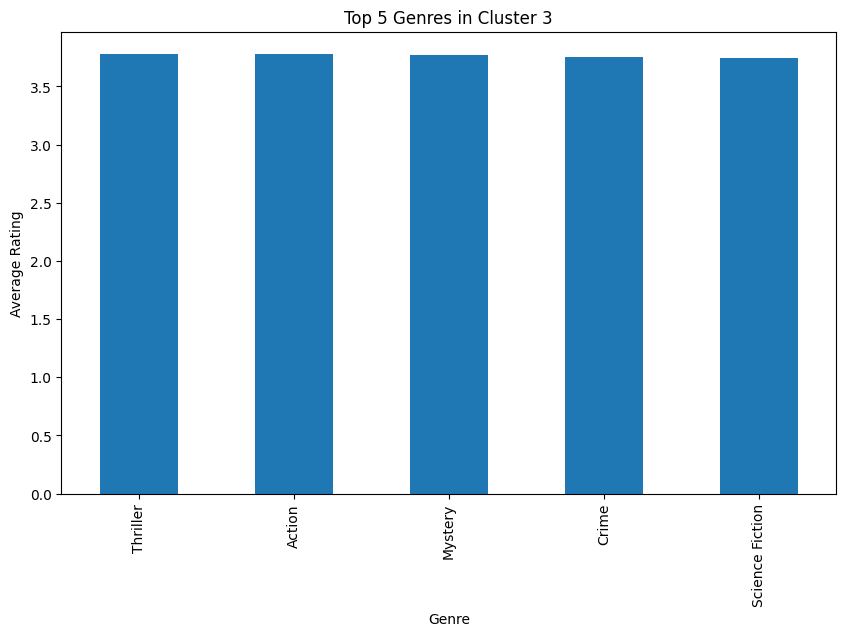

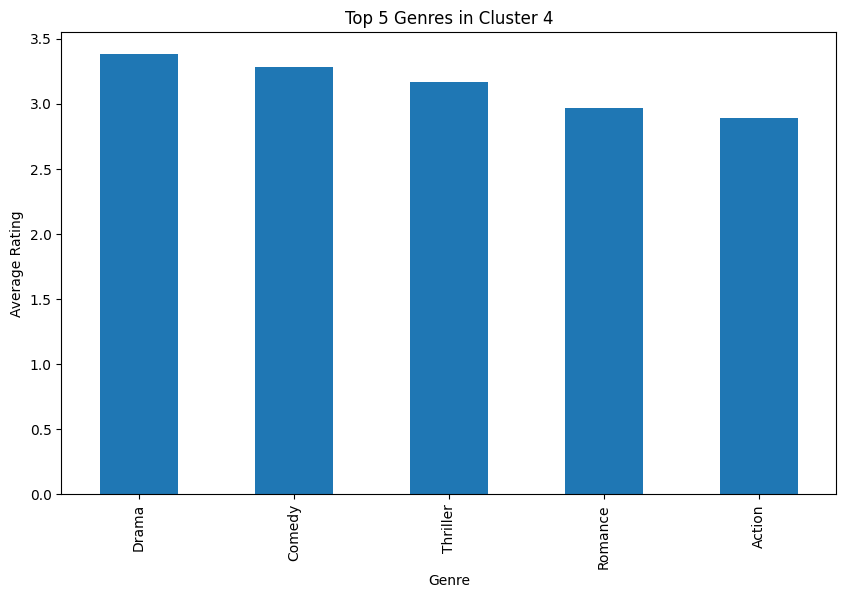

In [91]:
user_counts = user_genre_df['kmeans_cluster'].value_counts()
print("Number of users in each cluster:")
print(user_counts)

# Step 7: Identify Genres per Cluster
# Calculate the mean rating for each genre in each cluster
genre_means = user_genre_df.groupby('kmeans_cluster').mean()

# Step 8: Visualization of Genres per Cluster
num_clusters = kmeans.n_clusters
num_top_genres = 5  # Number of top genres to display for each cluster

for i in range(num_clusters):
    plt.figure(figsize=(10, 6))
    cluster_genres = genre_means.loc[i].sort_values(ascending=False)[:num_top_genres]
    cluster_genres.plot(kind='bar')
    plt.title(f'Top {num_top_genres} Genres in Cluster {i}')
    plt.ylabel('Average Rating')
    plt.xlabel('Genre')
    plt.show()

In [92]:
user_genre_df = user_genre_df.drop(columns=['kmeans_cluster'])


gmm = GaussianMixture(n_components=5)  # Adjust number of components as needed
user_genre_df['gmm_cluster'] = gmm.fit_predict(user_genre_df)

In [93]:
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(user_genre_df)

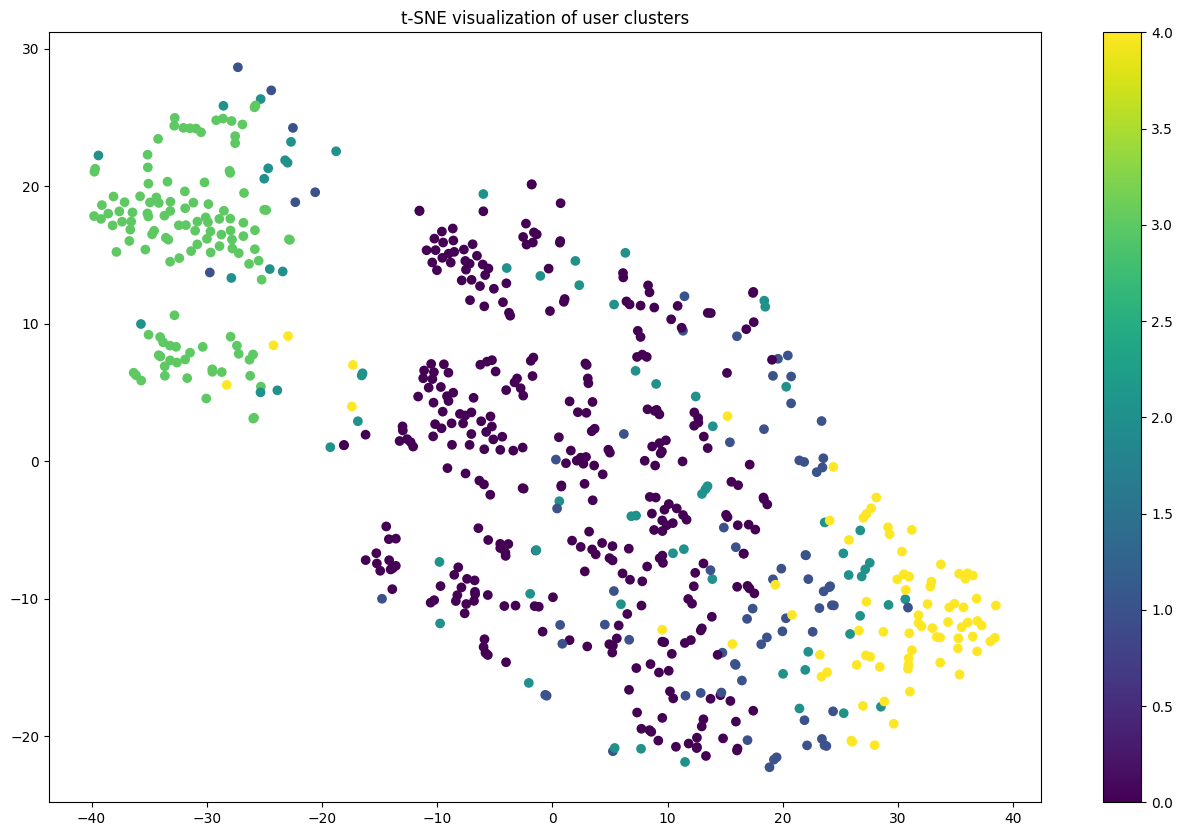

In [94]:
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=user_genre_df['gmm_cluster'])
plt.colorbar()
plt.title('t-SNE visualization of user clusters')
plt.show()

Number of users in each cluster:
0    328
3    122
4     79
1     74
2     68
Name: gmm_cluster, dtype: int64


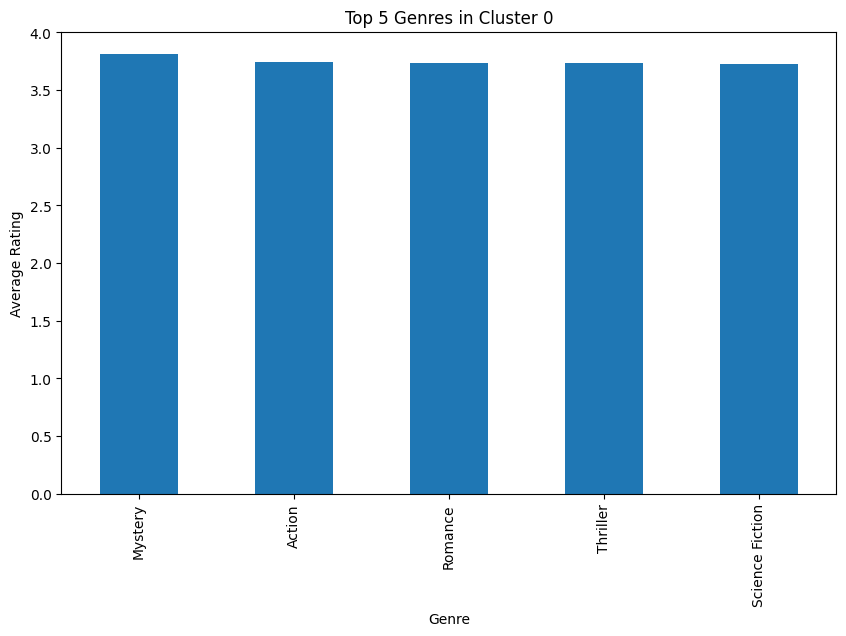

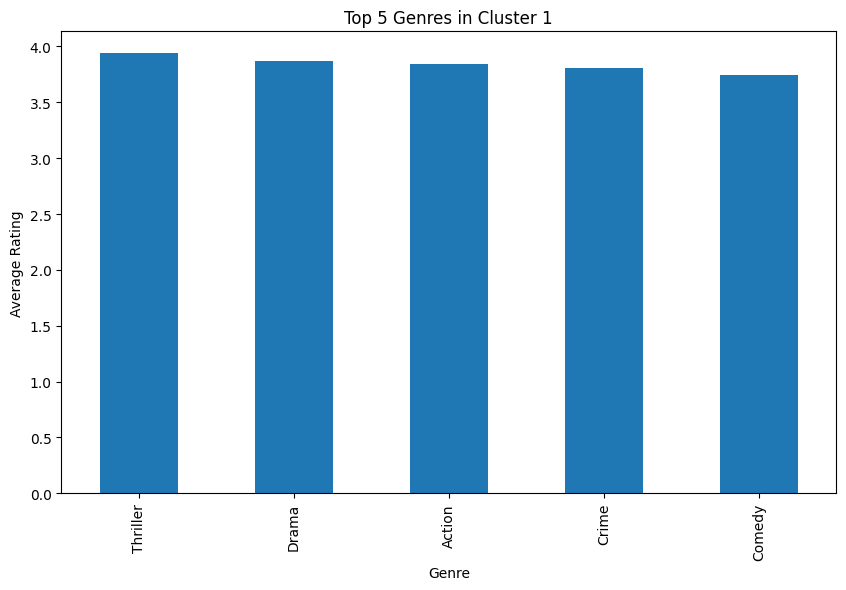

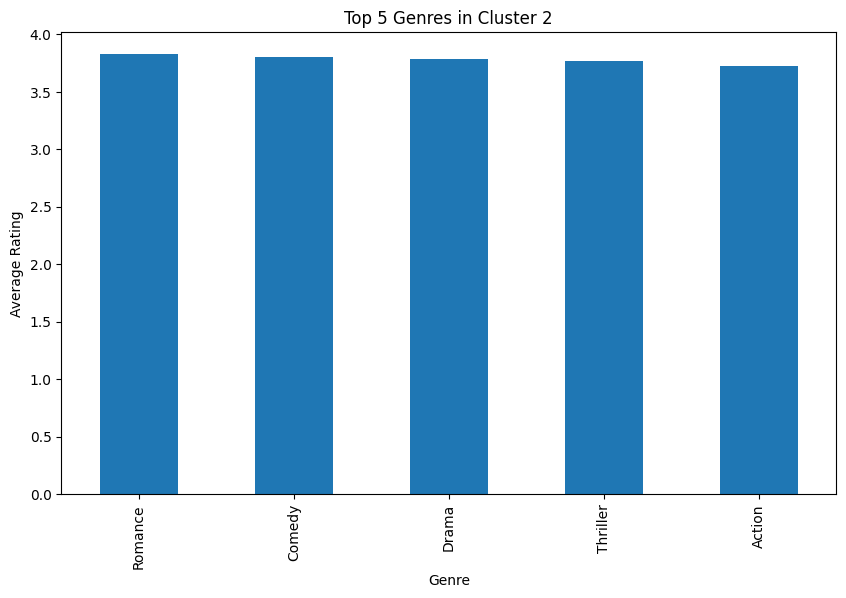

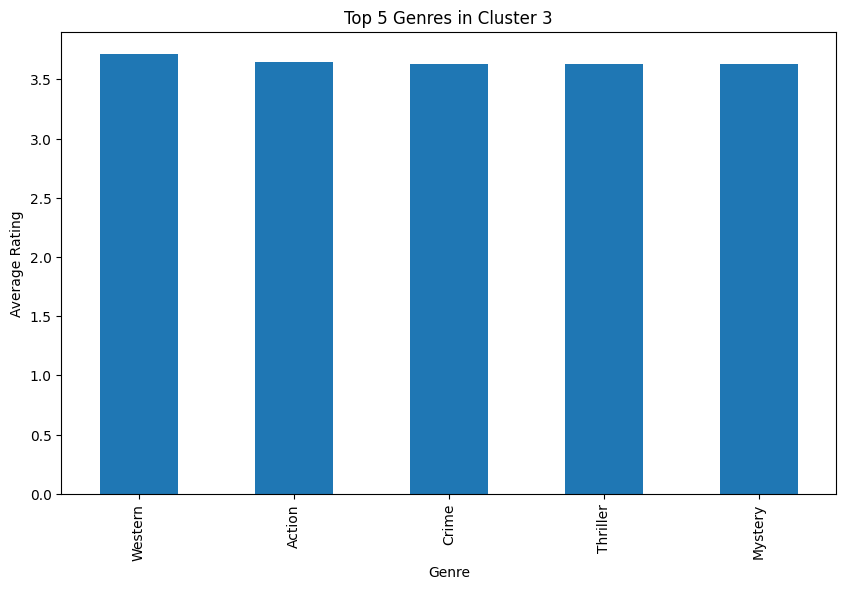

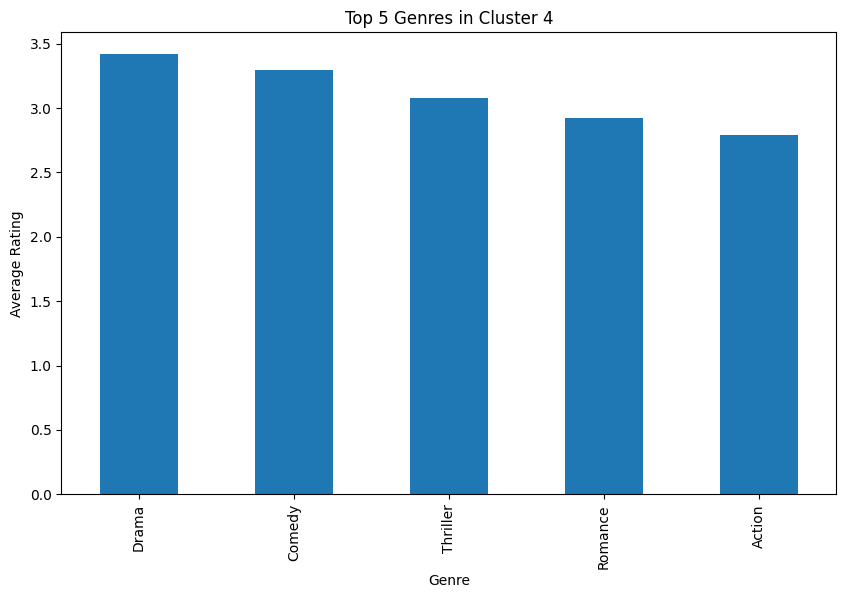

In [95]:
user_counts = user_genre_df['gmm_cluster'].value_counts()
print("Number of users in each cluster:")
print(user_counts)

# Step 7: Identify Genres per Cluster
# Calculate the mean rating for each genre in each cluster
genre_means = user_genre_df.groupby('gmm_cluster').mean()

# Step 8: Visualization of Genres per Cluster
num_clusters = gmm.n_components
num_top_genres = 5  # Number of top genres to display for each cluster

for i in range(num_clusters):
    plt.figure(figsize=(10, 6))
    cluster_genres = genre_means.loc[i].sort_values(ascending=False)[:num_top_genres]
    cluster_genres.plot(kind='bar')
    plt.title(f'Top {num_top_genres} Genres in Cluster {i}')
    plt.ylabel('Average Rating')
    plt.xlabel('Genre')
    plt.show()